Predicting the furture values of time series can be valuable for many different reasons. It allows business to forecast spending, employment needs, or future sales. Often, a simple linear regression can not deal with the underlying seasonality component of time series data. For example, champagne sales would be expected to peak near New Year's Eve each year. In order to capture the seasonality component, we can use Holt Winter's Exponential Smoothing Model to make time series predictions with seasonality components. We will compare our results with a lienar regression to illustrate the differences.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import holtwinters
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

To demonstrate, we'll use champagne-sales dataset which is available as part of the Udacity Time Series Forecasting class. The csv file is formatted for use with Altyrx software platform, so we will need to do some quick data wrangling to clean it up. There are 96 observations representing 8 years of monthly data. After reading in the data we will create a DatetimeIndex and drop the original `Month` column.

In [2]:
# Read in the data.
data = pd.read_csv('champagne-sales.csv')

In [3]:
# there are 96 observations representing 8 years of monthly data
data.index = pd.date_range(start='2010-01-01', periods=len(data), freq='m')

In [4]:
data.drop('Month',axis=1,inplace=True)

Plotting the data is always a good first step to develop some intuition and understanding the data set.

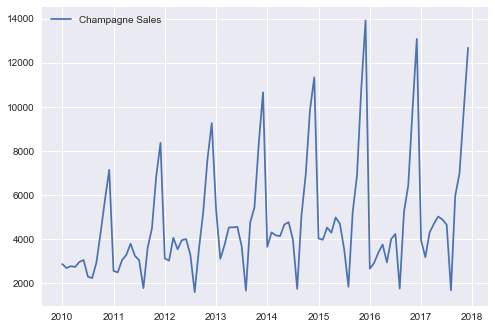

In [5]:
data.plot(kind='line')
plt.show();

We can see that there are peaks and valleys within each year of data. It looks like the peaks are trending upwards over time. There appears to be a pattern that repeats each year, suggesting we have a seasonality component in the dataset. We can decompose the time series into its trend and seasonality components using the tsa.decompose method available in statsmodels. This will allow us to understand the trend, seasonality and error components individually. 

We can make one of two assumptions during the decomposition - 1) that the trend, seasonality, and error terms are additive or 2) that they are multiplicative. Additive means the model terms add linearly, while multiplicative means they change exponenitally over time. Since we can't know ahead which is best to use, we will try both and choose the one that describes the data best.

We also want to specify the frequency of the time series. (This can actually be done automatically becuase we are using a Pandas DatetimeIndex). In this case, therequency is 12 becuase we are dealing with monthly data over a period of several years. You can confirm this yourself by trying different values for the freq parameter. When the freq is less than 12, the trend component displays seasonality.

First, we'll try the additive model.

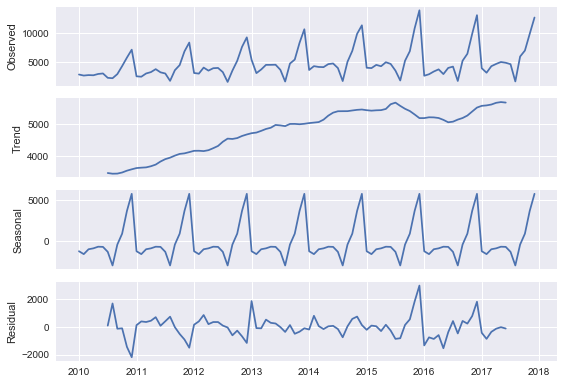

In [6]:
decompose = sm.tsa.seasonal_decompose(data['Champagne Sales'], model='additive', freq=12)
decompose.plot()
plt.show();

Each panel shows a different decomposition of the data. The Observed panel shows the original data, the Trend panel shows the overall trend, the Seasonal panel shows the seasonality component, and the Residual panel shows the data not captured by the trend or seasonality component. Notice the scale of the residual plot. The error term is plus or minus 2000! Now we can try the multiplicative model.

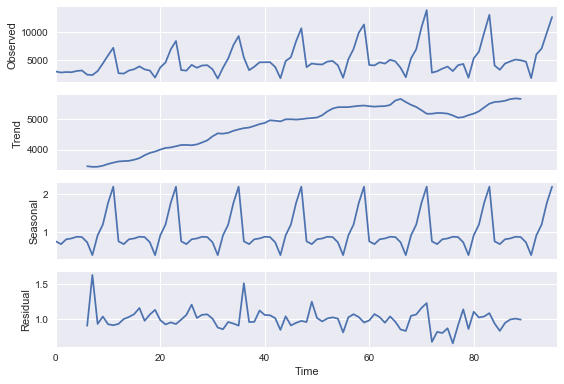

In [7]:
decompose = sm.tsa.seasonal_decompose(data['Champagne Sales'].values, model='multiplicative', freq=12)
decompose.plot()
plt.show();

A multiplicative model has a much smaller residual, indicating this model type is better for the current data set. Now we can fit a multiplicative Holt Winter's Exponential Smoothing model to the data and make some predictions. First, we need to split the data into a training and a test set. Then we will fit the model and make our predictions.

In [8]:
train, test = data.iloc[:90,0], data.iloc[90:,0]

In [9]:
model = holtwinters.ExponentialSmoothing(train, trend=None, seasonal='multiplicative', seasonal_periods=12).fit()

In [10]:
pred = model.predict(start=test.index[0], end=test.index[-1])

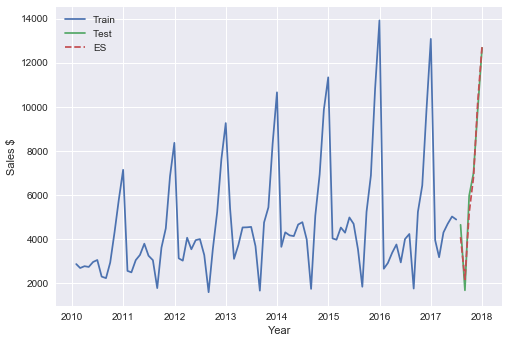

In [11]:
plt.plot(train)
plt.plot(test)
plt.plot(pred, '--')
plt.legend(['Train','Test','ES'])
plt.ylabel('Sales $')
plt.xlabel('Year')
plt.show()

We can evaluate the accuracy of our model using the root mean square error:

In [12]:
def rmse(pred, truth):
    return (np.sum((pred-truth)**2)/len(pred))**0.5
print(rmse(pred, test))

466.751386546


We got an RMSE of close to \$470, meaning we can expect to be about that close to truth with our future predictions. That seems good considering the peak sales are more \$12000 per month. That equates to an error of about 4%. However, at the trough, being off by \$470 is alost 25% off from truth. Let's compare this amount of error with a linear regression to illustrate the value of Holt Winter's Model being able to capture the trend and seasonality component.

In [13]:
X = np.arange(len(data)).reshape(-1,1)
y = data.values.reshape(-1,1)
split_ix = len(train)
Xtrain, ytrain, Xtest, ytest = X[:split_ix], y[:split_ix], X[split_ix:], y[split_ix:]

In [14]:
lr = LinearRegression()
lr.fit(Xtrain, ytrain)
lr_pred = lr.predict(Xtest)

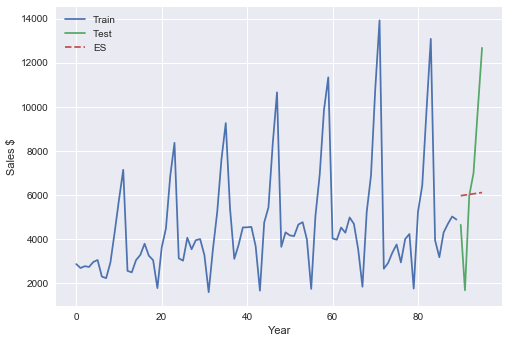

In [15]:
plt.plot(Xtrain, ytrain)
plt.plot(Xtest, ytest)
plt.plot(Xtest, lr_pred, '--')
plt.legend(['Train','Test','ES'])
plt.ylabel('Sales $')
plt.xlabel('Year')
plt.show()

In [16]:
print(rmse(lr_pred, ytest))

3624.32489061


Now we can see how much better the model is using Holt Winter's to take error, trend, and seasonality into account. The simple linear regression model has an RMSE of about \$3600, significantly worse than the first model!

In this post you have learned:
- how to use Python for time series forecasting
- how to identify whether to use a multiplicative or additive Holt Winter's Exponential Smoothing model
- how Holt Winter's extends and improves on simple linear regression